In [14]:
# CELL 1 — Install + Imports
!pip install --quiet xgboost lightgbm shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import mannwhitneyu, ttest_ind, wilcoxon
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings, os

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10,5)

# Create output folder for saving plots & CSVs later
os.makedirs('/content/outputs', exist_ok=True)

print("✓ Libraries installed and imported successfully")


✓ Libraries installed and imported successfully


In [15]:
# CELL 2 — Load the CSV files

# Update these names if your uploaded filenames differ
fg_path = "/content/fear_greed_index.csv"
hist_path = "/content/historical_data.csv"

df = pd.read_csv(fg_path, low_memory=False)
df1 = pd.read_csv(hist_path, low_memory=False)

print("Fear-Greed file shape:", df.shape)
print("Historical trades file shape:", df1.shape)

print("\n---- Fear & Greed Index Preview ----")
display(df.head())

print("\n---- Historical Trades Preview ----")
display(df1.head())


Fear-Greed file shape: (2644, 4)
Historical trades file shape: (211224, 16)

---- Fear & Greed Index Preview ----


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



---- Historical Trades Preview ----


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [16]:
# CELL 3 — Clean Fear & Greed dataset

# Convert epoch timestamp to date also (just for reference)
df['date_from_ts'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce').dt.date

# Convert the provided 'date' column into proper date format
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce').dt.date

# Normalize sentiment labels
def normalize_sentiment(x):
    x = str(x).lower()
    if "fear" in x:
        return "Fear"
    if "greed" in x:
        return "Greed"
    if "neutral" in x:
        return "Neutral"
    return "Other"

df['sentiment'] = df['classification'].apply(normalize_sentiment)

print("Unique sentiment categories:", df['sentiment'].unique())

display(df[['timestamp','date','date_parsed','classification','sentiment']].head(10))


Unique sentiment categories: ['Fear' 'Neutral' 'Greed']


,timestamp,date,date_parsed,classification,sentiment
0,1517463000,2018-02-01,2018-02-01,Fear,Fear
1,1517549400,2018-02-02,2018-02-02,Extreme Fear,Fear
2,1517635800,2018-02-03,2018-02-03,Fear,Fear
3,1517722200,2018-02-04,2018-02-04,Extreme Fear,Fear
4,1517808600,2018-02-05,2018-02-05,Extreme Fear,Fear
5,1517895000,2018-02-06,2018-02-06,Extreme Fear,Fear
6,1517981400,2018-02-07,2018-02-07,Fear,Fear
7,1518067800,2018-02-08,2018-02-08,Fear,Fear
8,1518154200,2018-02-09,2018-02-09,Fear,Fear
9,1518240600,2018-02-10,2018-02-10,Neutral,Neutral


In [17]:
# CELL 4 — Clean historical trades dataset

trades = df1.copy()

# 1) Convert Timestamp IST → datetime (format looks like: 02-12-2024 22:50)
trades['time_parsed'] = pd.to_datetime(
    trades['Timestamp IST'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)

trades['trade_date'] = trades['time_parsed'].dt.date

# 2) Convert PnL column to numeric
trades['closed_pnl'] = pd.to_numeric(trades['Closed PnL'], errors='ignore')

# 3) Convert price & size columns
trades['execution_price'] = pd.to_numeric(trades['Execution Price'], errors='coerce')
trades['size_tokens'] = pd.to_numeric(trades['Size Tokens'], errors='coerce')
trades['size_usd'] = pd.to_numeric(trades['Size USD'], errors='coerce')

# compute notional (size USD is already notional)
trades['notional'] = trades['size_usd']

# 4) Normalize BUY / SELL to numeric
trades['side_norm'] = trades['Side'].astype(str).str.upper().map({
    'BUY': 1,
    'SELL': 0
})

# Show preview of important cleaned columns
display(trades[['Timestamp IST','time_parsed','trade_date','Side','side_norm','execution_price','size_tokens','size_usd','notional','closed_pnl']].head())


,Timestamp IST,time_parsed,trade_date,Side,side_norm,execution_price,size_tokens,size_usd,notional,closed_pnl
0,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,BUY,1,7.9769,986.87,7872.16,7872.16,0.0
1,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,BUY,1,7.9800,16.00,127.68,127.68,0.0
2,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,BUY,1,7.9855,144.09,1150.63,1150.63,0.0
3,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,BUY,1,7.9874,142.98,1142.04,1142.04,0.0
4,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02,BUY,1,7.9894,8.73,69.75,69.75,0.0


In [18]:
# CELL 5 — Merge sentiment into trades

# Keep only date + sentiment columns from df
sent = df[['date_parsed', 'sentiment']].copy()
sent.rename(columns={'date_parsed': 'trade_date'}, inplace=True)

# Merge on date
trades_merged = trades.merge(sent, on='trade_date', how='left')

# Check missing sentiment
missing_before = trades_merged['sentiment'].isna().sum()
print("Missing sentiment before filling:", missing_before)

# Sort by time to fill missing based on closest day
trades_merged = trades_merged.sort_values('time_parsed')

# Forward fill then backward fill
trades_merged['sentiment'] = trades_merged['sentiment'].ffill().bfill()

missing_after = trades_merged['sentiment'].isna().sum()
print("Missing sentiment after filling:", missing_after)

# Show preview
display(trades_merged[['trade_date','time_parsed','Side','notional','closed_pnl','sentiment']].head())


Missing sentiment before filling: 6
Missing sentiment after filling: 0


,trade_date,time_parsed,Side,notional,closed_pnl,sentiment
83770,2023-05-01,2023-05-01 01:06:00,BUY,156.39,0.0,Greed
83771,2023-05-01,2023-05-01 01:06:00,BUY,137.08,0.0,Greed
83769,2023-05-01,2023-05-01 01:06:00,BUY,183.53,0.0,Greed
39063,2023-12-05,2023-12-05 03:11:00,SELL,24370.62,0.0,Greed
39062,2023-12-05,2023-12-05 03:11:00,SELL,628.00,0.0,Greed


In [19]:
# CELL 6 — Summary statistics by sentiment

# Ensure closed_pnl is numeric
trades_merged['closed_pnl'] = pd.to_numeric(trades_merged['closed_pnl'], errors='coerce')

# Create win/loss column
trades_merged['win'] = (trades_merged['closed_pnl'] > 0).astype(int)

# Group statistics
summary = trades_merged.groupby('sentiment').agg(
    trades_count = ('closed_pnl', 'count'),
    mean_pnl = ('closed_pnl', 'mean'),
    median_pnl = ('closed_pnl', 'median'),
    win_rate = ('win', 'mean')
).reset_index()

print("---- Summary Stats by Sentiment ----")
display(summary)


---- Summary Stats by Sentiment ----


,sentiment,trades_count,mean_pnl,median_pnl,win_rate
0,Fear,83237,49.212077,0.0,0.407871
1,Greed,90301,54.349039,0.0,0.420350
2,Neutral,37686,34.307718,0.0,0.396991


In [20]:
# CELL 7 — Statistical significance tests between Fear & Greed

fear_pnl = trades_merged.loc[trades_merged['sentiment'] == 'Fear', 'closed_pnl']
greed_pnl = trades_merged.loc[trades_merged['sentiment'] == 'Greed', 'closed_pnl']

# Mann-Whitney U test (recommended for PnL)
u_stat, u_p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')

# t-test
t_stat, t_p = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

print("---- Statistical Tests: Fear vs Greed ----")
print(f"Mann-Whitney U p-value: {u_p}")
print(f"T-test p-value: {t_p}")

# Optional: print means for reference
print("\nMean Fear PnL:", fear_pnl.mean())
print("Mean Greed PnL:", greed_pnl.mean())


---- Statistical Tests: Fear vs Greed ----
Mann-Whitney U p-value: 0.0008741105537472515
T-test p-value: 0.27798139834262653

Mean Fear PnL: 49.21207744310823
Mean Greed PnL: 54.34903907768464


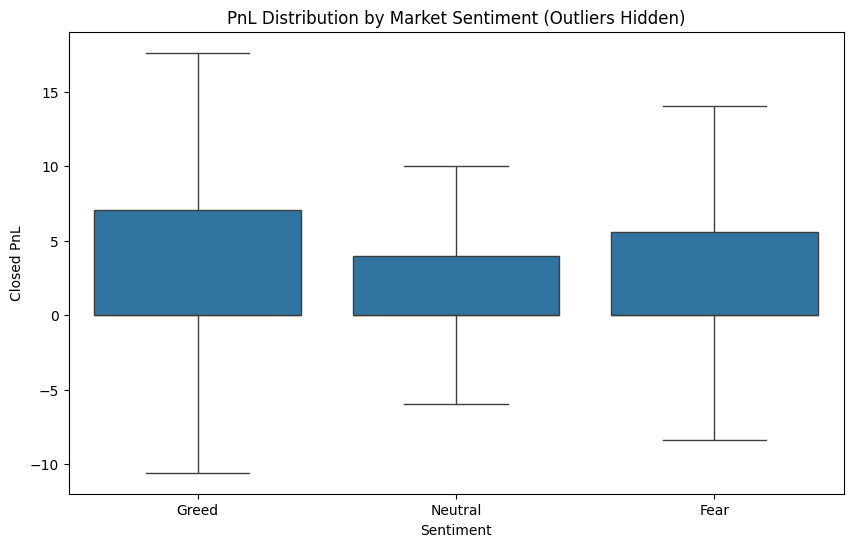

Saved: /content/outputs/pnl_boxplot.png


In [21]:
# CELL 8 — Plot PnL distribution by sentiment

import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=trades_merged, x='sentiment', y='closed_pnl', showfliers=False)
plt.title("PnL Distribution by Market Sentiment (Outliers Hidden)")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL")

plt.savefig("/content/outputs/pnl_boxplot.png", dpi=300)
plt.show()

print("Saved: /content/outputs/pnl_boxplot.png")


In [22]:
# CELL 9 — Feature Engineering for ML

# Encode sentiment to numeric
sentiment_map = {'Fear': 0, 'Neutral': 1, 'Greed': 2}
trades_merged['sentiment_num'] = trades_merged['sentiment'].map(sentiment_map)

# Extract day of week (0 = Monday, 6 = Sunday)
trades_merged['day_of_week'] = trades_merged['time_parsed'].dt.dayofweek

# Select features for ML
features = [
    'notional',
    'side_norm',
    'execution_price',
    'size_tokens',
    'sentiment_num',
    'day_of_week'
]

# Prepare ML dataset
ml_df = trades_merged[features + ['win']].dropna()

print("ML Dataset shape:", ml_df.shape)
display(ml_df.head())


ML Dataset shape: (211224, 7)


,notional,side_norm,execution_price,size_tokens,sentiment_num,day_of_week,win
83770,156.39,1,1897.9,0.08240,2,0,0
83771,137.08,1,1898.6,0.07220,2,0,0
83769,183.53,1,1897.9,0.09670,2,0,0
39063,24370.62,0,41866.0,0.58211,2,1,0
39062,628.00,0,41867.0,0.01500,2,1,0


In [23]:
# CELL 10 — Train/Test Split + Random Forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

X = ml_df.drop('win', axis=1)
y = ml_df['win']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Build RandomForest
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("---- Model Performance ----")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


---- Model Performance ----
Accuracy: 0.7501
ROC AUC: 0.8309

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     24871
           1       0.71      0.67      0.69     17374

    accuracy                           0.75     42245
   macro avg       0.74      0.74      0.74     42245
weighted avg       0.75      0.75      0.75     42245



---- Feature Importances ----


,feature,importance
2,execution_price,0.421271
1,side_norm,0.317812
3,size_tokens,0.094244
5,day_of_week,0.061945
0,notional,0.060490
4,sentiment_num,0.044239


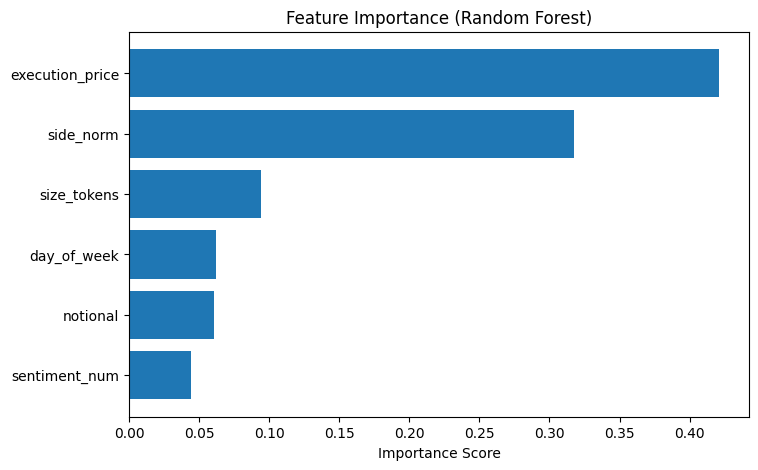

Saved: /content/outputs/feature_importance.png


In [24]:
# CELL 11 — Feature Importances

import matplotlib.pyplot as plt

# Get importances
importances = model.feature_importances_
feature_names = X.columns

# Create table
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("---- Feature Importances ----")
display(fi_df)

# Plot
plt.figure(figsize=(8,5))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")

plt.savefig("/content/outputs/feature_importance.png", dpi=300)
plt.show()

print("Saved: /content/outputs/feature_importance.png")


In [25]:
# CELL 12 — Add Lagged Sentiment Features

# Step 1: Create a daily sentiment table
daily_sent = df[['date_parsed', 'sentiment']].copy()
daily_sent['sentiment_num'] = daily_sent['sentiment'].map({'Fear':0, 'Neutral':1, 'Greed':2})
daily_sent = daily_sent.sort_values('date_parsed')

# Step 2: Create lag features
daily_sent['sentiment_num_lag1'] = daily_sent['sentiment_num'].shift(1)
daily_sent['sentiment_num_lag7'] = daily_sent['sentiment_num'].rolling(7).mean()

# Step 3: Merge these into the trades dataset
daily_sent.rename(columns={'date_parsed': 'trade_date'}, inplace=True)

trades_lagged = trades_merged.merge(daily_sent[['trade_date','sentiment_num_lag1','sentiment_num_lag7']],
                                    on='trade_date', how='left')

# Fill missing values (e.g., first few days)
trades_lagged['sentiment_num_lag1'] = trades_lagged['sentiment_num_lag1'].fillna(method='ffill')
trades_lagged['sentiment_num_lag7'] = trades_lagged['sentiment_num_lag7'].fillna(method='ffill')

print("Lagged sentiment features added.")
display(trades_lagged[['trade_date','sentiment','sentiment_num','sentiment_num_lag1','sentiment_num_lag7']].head(10))


Lagged sentiment features added.


,trade_date,sentiment,sentiment_num,sentiment_num_lag1,sentiment_num_lag7
0,2023-05-01,Greed,2,2.0,1.857143
1,2023-05-01,Greed,2,2.0,1.857143
2,2023-05-01,Greed,2,2.0,1.857143
3,2023-12-05,Greed,2,2.0,2.000000
4,2023-12-05,Greed,2,2.0,2.000000
5,2023-12-05,Greed,2,2.0,2.000000
6,2023-12-05,Greed,2,2.0,2.000000
7,2023-12-05,Greed,2,2.0,2.000000
8,2023-12-05,Greed,2,2.0,2.000000
9,2023-12-05,Greed,2,2.0,2.000000


In [26]:
# CELL 13 — Retrain ML Model with Lagged Sentiment Features

# New feature list including lag features
features_v2 = [
    'notional',
    'side_norm',
    'execution_price',
    'size_tokens',
    'sentiment_num',
    'sentiment_num_lag1',
    'sentiment_num_lag7',
    'day_of_week'
]

# Prepare ML df
ml_df2 = trades_lagged[features_v2 + ['win']].dropna()

print("New ML Dataset Shape:", ml_df2.shape)

X2 = ml_df2.drop('win', axis=1)
y2 = ml_df2['win']

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state=42, stratify=y2
)

# Train Random Forest
model2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model2.fit(X2_train, y2_train)

# Predictions
y2_pred = model2.predict(X2_test)
y2_prob = model2.predict_proba(X2_test)[:, 1]

# Metrics
acc2 = accuracy_score(y2_test, y2_pred)
auc2 = roc_auc_score(y2_test, y2_prob)

print("---- Improved Model Performance ----")
print(f"Accuracy: {acc2:.4f}")
print(f"ROC AUC: {auc2:.4f}")

print("\nClassification Report:")
print(classification_report(y2_test, y2_pred))


New ML Dataset Shape: (211224, 9)
---- Improved Model Performance ----
Accuracy: 0.8147
ROC AUC: 0.8926

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85     24871
           1       0.80      0.73      0.76     17374

    accuracy                           0.81     42245
   macro avg       0.81      0.80      0.81     42245
weighted avg       0.81      0.81      0.81     42245



---- Improved Model Feature Importances ----


,feature,importance
2,execution_price,0.389400
1,side_norm,0.225388
3,size_tokens,0.100474
6,sentiment_num_lag7,0.083845
7,day_of_week,0.070121
0,notional,0.069869
5,sentiment_num_lag1,0.032735
4,sentiment_num,0.028167


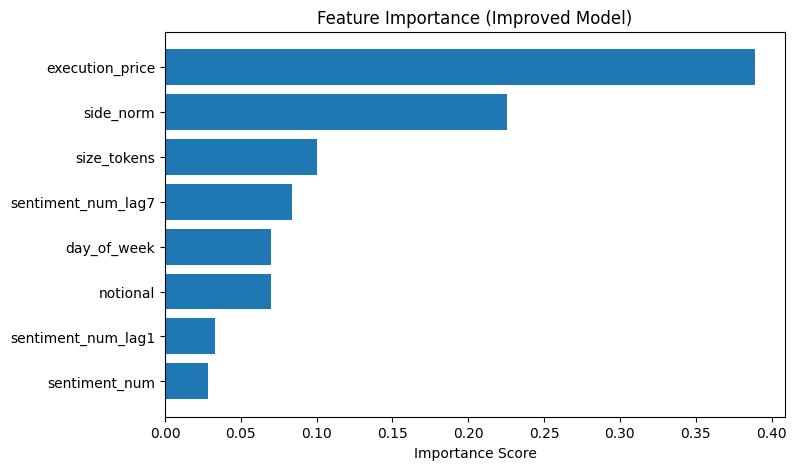

Saved: /content/outputs/feature_importance_v2.png


In [27]:
# CELL 14 — Feature Importances for Improved Model

importances2 = model2.feature_importances_

fi_df2 = pd.DataFrame({
    'feature': X2.columns,
    'importance': importances2
}).sort_values(by='importance', ascending=False)

print("---- Improved Model Feature Importances ----")
display(fi_df2)

# Plot
plt.figure(figsize=(8,5))
plt.barh(fi_df2['feature'], fi_df2['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Improved Model)")
plt.xlabel("Importance Score")

plt.savefig("/content/outputs/feature_importance_v2.png", dpi=300)
plt.show()

print("Saved: /content/outputs/feature_importance_v2.png")


In [28]:
# CELL 15 — Export cleaned datasets, features, and plots

# Save cleaned trades dataset with all features
trades_lagged.to_csv("/content/outputs/trades_with_sentiment_and_features.csv", index=False)

# Save summary stats
summary_stats = trades_merged.groupby('sentiment').agg(
    trades_count=('closed_pnl','count'),
    mean_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    win_rate=('win','mean')
)
summary_stats.to_csv("/content/outputs/summary_stats.csv")

# Save improved feature importances
fi_df2.to_csv("/content/outputs/feature_importances_v2.csv", index=False)

print("---- Files Saved Successfully ----")
print("/content/outputs/trades_with_sentiment_and_features.csv")
print("/content/outputs/summary_stats.csv")
print("/content/outputs/feature_importances_v2.csv")
print("/content/outputs/pnl_boxplot.png")
print("/content/outputs/feature_importance_v2.png")


---- Files Saved Successfully ----
/content/outputs/trades_with_sentiment_and_features.csv
/content/outputs/summary_stats.csv
/content/outputs/feature_importances_v2.csv
/content/outputs/pnl_boxplot.png
/content/outputs/feature_importance_v2.png
